In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('default')
from matplotlib import rc
rc('text', usetex=True)
import seaborn as sns


import sys, re, time, json
from PSlim import Experiment, get_eps, ROC

pyslurm = '/home/enes/pyslurm/'
#pyslurm = None

In [2]:
Train = False # False if you do analysis with given simulations and estimates

In [3]:
if pyslurm:
    sys.path.append(pyslurm)
    from pyslurm import Slurm

    slurm = Slurm(account='stats_dept1')

    srun = slurm.batch('source activate slim', 
                       '#time=0-1:00:00',
                       '#mem=1000M',
                       '#mem-per-cpu=None', 
                       '#job-name="sim"')   

    srun_est = slurm.batch('module load python3.8-anaconda/2020.07', 
                           '#mem-per-cpu=300',
                           '#job-name="est"',
                           '#cpus-per-task=2')

### Parameters:

In [4]:
N = 250
Ne = 1000
L = 2500
r = 1.25e-7
mu = 2.5e-7

extmut = 0 # no extra mutation (just one)
Until = 100000 # make sure model runs until it reaches the desired frequency Until>>Ne

Args = {}

Args['Neut'] = {'Simulator':'slim', 'slimTxt':'Constant_mt.txt', 
                'N':N, 'L':L, 'r':r, 'mu':mu, 'Ne':Ne,
                'Until':Until,
                's':0, 'h':0.5, 
                'srun':srun, 'srun_est':srun_est,
                'etapath':'etas/BC.json', 'start': Until + 100,
                'name':'Neutral Model',
                'Freq':1000000,
                'rep':0,
                'reset_lost': 0}

h = 25
for Until in [2000, 3000, 4000, 5000]:
    for s in [0.01/h, 0.02/h, 0.05/h]:
        name = 'until='+str(Until)+'s='+str(s)
        arg = Args['Neut'].copy()
        arg['s'] = s
        arg['h'] = h
        arg['name'] = name
        arg['reset_lost'] = 1
        arg['Until'] = Until
        Args[name] = arg

In [5]:
cID = 8 # simulation class id for directional selection constant pop size simulations
nrep = 250
X = Experiment(cID, nrep, Args)

## 2 Population Size History estimation

In [10]:
X.calc_sfs()
X.train_eta()

Done!


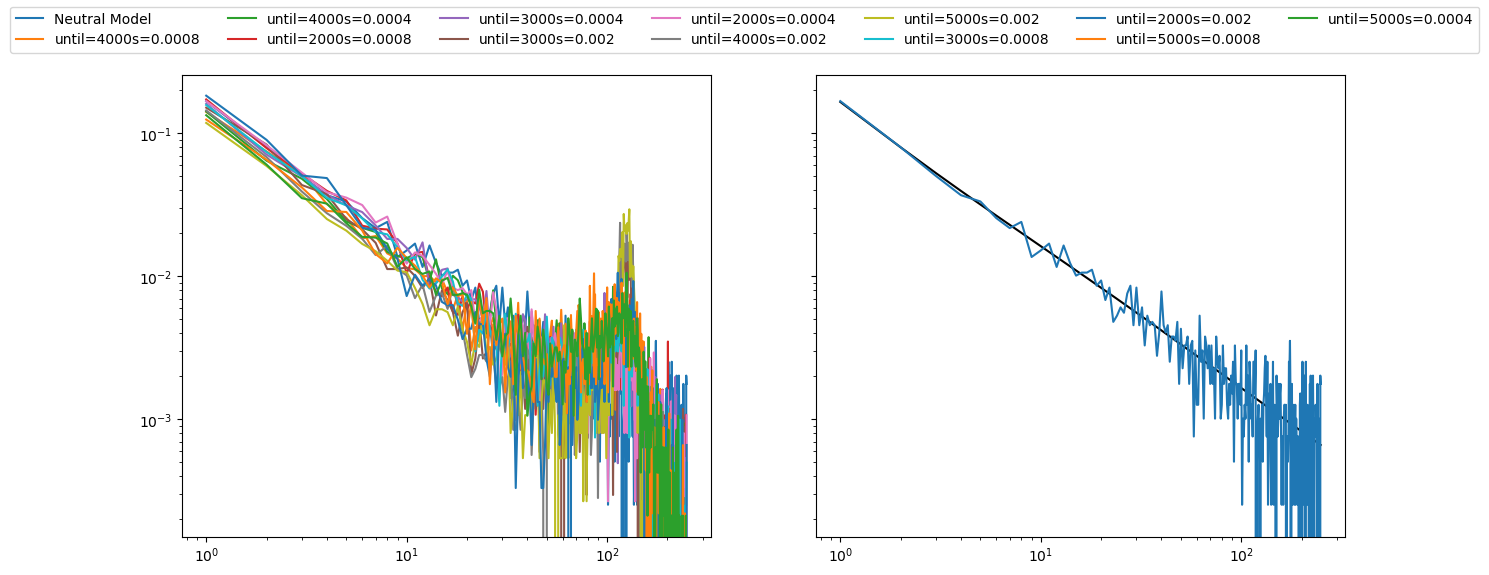

In [11]:
fig, ax = plt.subplots(1,2,figsize = (15,6), sharex=True, sharey=True)

for setid in X.neutrals:
    name = Args[setid]['name']
    ax[1].plot(range(1, len(X.AFS[setid])+1), X.ebl[setid]/X.ebl[setid].sum(), color = 'black')
    ax[1].plot(range(1, len(X.AFS[setid])+1), X.AFS[setid]/X.AFS[setid].sum())
    ax[0].plot(range(1, len(X.AFS[setid])+1), X.AFS[setid]/X.AFS[setid].sum(), label = name)

for setid in set(X.setids).difference(X.neutrals):
    name = Args[setid]['name']
    ax[0].plot(range(1, len(X.AFS[setid])+1), X.AFS[setid]/X.AFS[setid].sum(), label = name)

ax[1].set_xscale('log')
ax[1].set_yscale('log')
fig.legend(ncol = 7, loc = 'upper center')

## 3 Optimizing $\beta$-imbalance and calculating summary stats

In [7]:
treews = ['none', 'split','branch']

In [12]:
import time
BIM = '/nfs/turbo/lsa-enes/bim/bim/BIM.py'
    
for treew in treews:
    
    for setid in X.setids:
        X.est(BIM, setid, now = 10, srun = srun_est, arg = '--r2t=0.005 --r2s=0.001 --treew='+treew)
    
    t = True
    while(t):
        time.sleep(10)
        try:
            if slurm.queue(by_name='est').shape[0] == 0:
                t = False
        except:
            pass
            
    
    for setid in X.setids:
        name = 'outs_weights_experiment/BS'+treew+setid+'.csv'
        X.merge_outs(setid, name = name)

If you are using HPC (srun is not None) check the jobs!
If you are using HPC (srun is not None) check the jobs!
If you are using HPC (srun is not None) check the jobs!
If you are using HPC (srun is not None) check the jobs!
If you are using HPC (srun is not None) check the jobs!
If you are using HPC (srun is not None) check the jobs!
If you are using HPC (srun is not None) check the jobs!
If you are using HPC (srun is not None) check the jobs!
If you are using HPC (srun is not None) check the jobs!
If you are using HPC (srun is not None) check the jobs!
If you are using HPC (srun is not None) check the jobs!
If you are using HPC (srun is not None) check the jobs!
If you are using HPC (srun is not None) check the jobs!
If you are using HPC (srun is not None) check the jobs!
If you are using HPC (srun is not None) check the jobs!
If you are using HPC (srun is not None) check the jobs!
If you are using HPC (srun is not None) check the jobs!
If you are using HPC (srun is not None) check th

In [6]:
stats = ['ibtree']

none 0.5244546666666666
split 0.5907486666666667
branch 0.6348146666666666


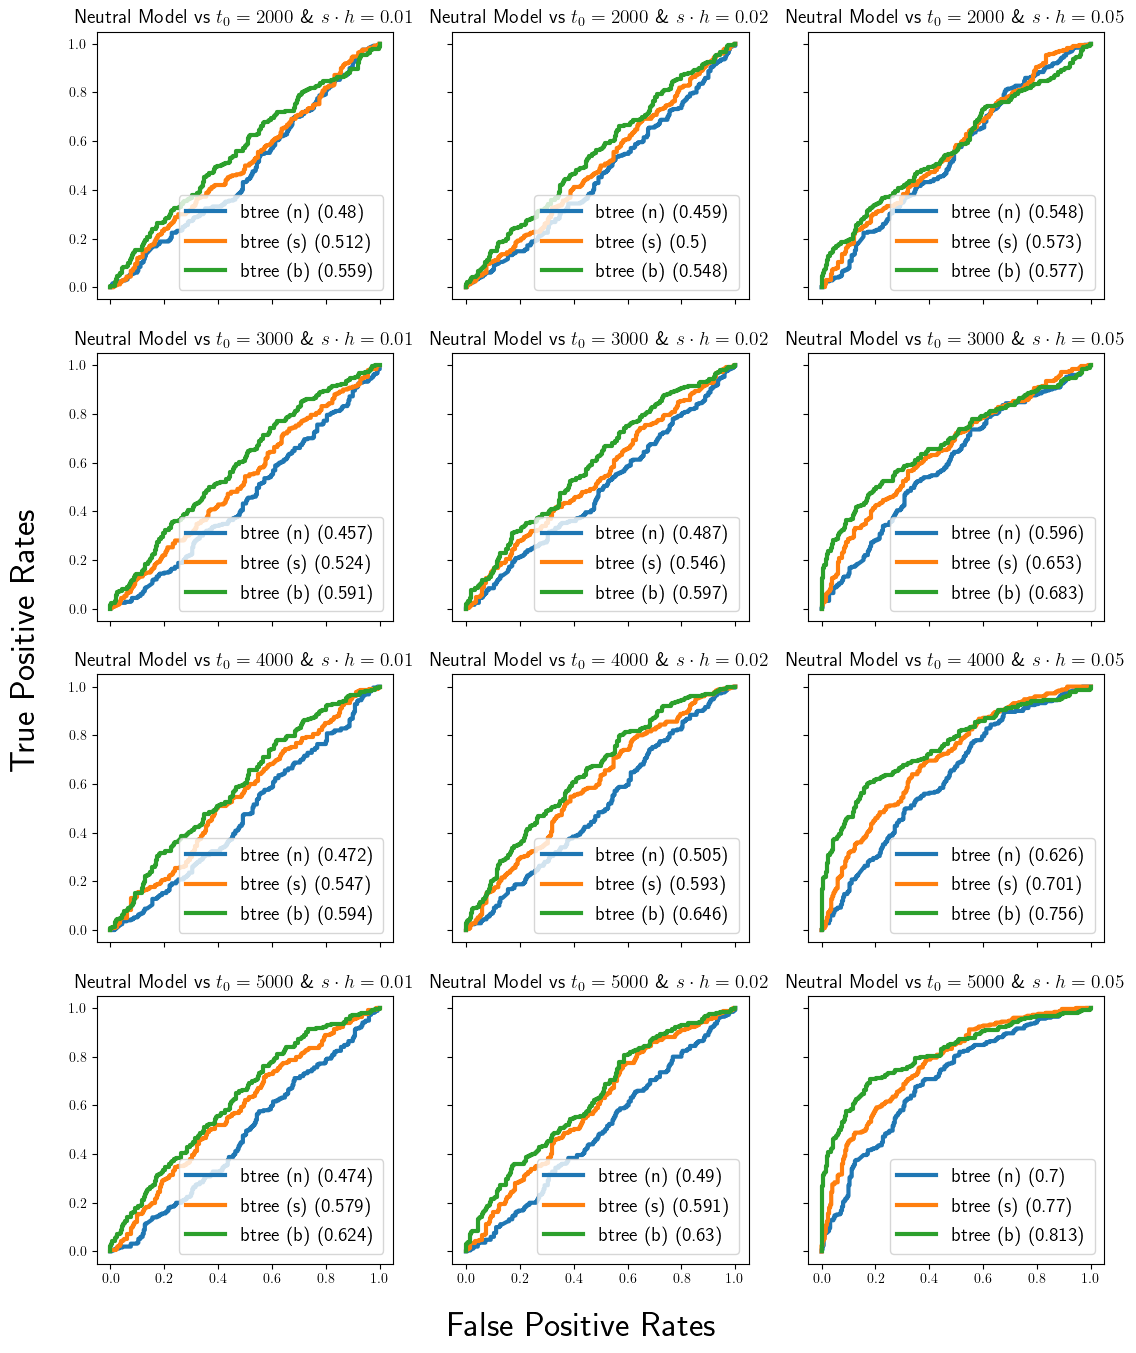

In [11]:
fig, ax = plt.subplots(4,3,figsize = (13,16), sharex = True, sharey = True)


for treew in treews:
    
    aucs = {stat:[] for stat in stats}
    for j, Until in enumerate([2000, 3000, 4000, 5000]):

        Vs = [['Neut', 'until='+str(Until)+'s='+str(s)] for s in [0.01/h, 0.02/h, 0.05/h]]
        names = [['Neutral Model', '$t_0='+str(Until)+'$ \& $s\cdot h='+str(s*h)+'$'] for s in [0.01/h, 0.02/h, 0.05/h]]

        for i, vs in zip(range(len(Vs)), Vs):
            for key in stats:
                k1, k2 = vs
                df1 = pd.read_csv('outs_weights_experiment/BS'+treew+k1+'.csv')
                df2 = pd.read_csv('outs_weights_experiment/BS'+treew+k2+'.csv')
                for pos in ['iColless', 'FulD']:
                    df1[pos] = -df1[pos]
                    df2[pos] = -df2[pos]

                if key == 'ibtree':
                    label = 'btree ('+treew[0]+')'
                elif key == 'iColless':
                    label = 'Colless'
                else:
                    label = key

                auc = ROC(ax[j, i], df1[key], df2[key], score_ascending = True, label = label)

                aucs[key].append(auc)

            handles, labels = ax[j,i].get_legend_handles_labels()
            ax[j, i].legend(loc = 'lower right', prop={'size': 14})


        for i, vs in zip(range(len(Vs)), Vs):
            k1, k2 = vs
            ax[j, i].set_title(names[i][0]+' vs '+names[i][1], size = 14)
            
    print(treew, np.mean(aucs[key]))

fig.text(0.5, 0.07, 'False Positive Rates', ha='center', va='center', size = 25)
fig.text(0.07, 0.5, 'True Positive Rates', rotation = 90, ha='center', va='center', size = 25)
plt.savefig('plots/Balancing_treew.pdf', dpi = 600, bbox_inches = 'tight')